# Capstone: Development of an algorithm for automatic detection of meniscus tears in radiographic images of the knee.

### Contents:
- [Background](#Background)
- [Data](#Data)
- [Building own models](#Building-own-models)
- [Evaluate results](#Evaluate-results)



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [237]:
# Import libraries here
import os
import tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from glob import glob
from IPython.display import Image, display
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

import random as random
import imageio
import imgaug as ia
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import save_img, load_img, img_to_array, array_to_img
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Average, Input, Activation, Reshape, TimeDistributed
from tensorflow.keras.layers import BatchNormalization, Concatenate, GlobalAveragePooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import AUC, Precision, Recall
pd.options.mode.chained_assignment = None  # default='warn'


**Data from [MRNet](https://stanfordmlgroup.github.io/competitions/mrnet/):** 
* Images of 1370 knee MRI exams performed at Stanford University Medical Center. The dataset contains 1,104 (80.6%) abnormal exams,  with 319 (23.3%) ACL tears and 508 (37.1%) meniscal tears; labels were obtained through manual extraction from clinical reports. 
* train set: consists of 1130 MRI images from coronal, sagittal and transverse planes
* valdation set: consists of 120 MRI images from coronal, sagittal and transverse planes


## Data import

**import data and get labels**

In [3]:
!unzip drive/My\ Drive/data.zip > /dev/null

In [4]:
train_path = 'data/train/'
valid_path = 'data/valid/'

In [5]:
datasets = {'train': train_path, 'valid': valid_path}
planes = ['axial', 'coronal', 'sagittal']
# diagnosis = ['abnormal','meniscus','acl']

In [6]:
def get_data(dataset_type, plane, diagnosis):
    '''this function gets the data from the original dataset'''
    # for eg, (train, sagittal, acl)
    if dataset_type == 'train':
        go = train_path
    else:
        go = valid_path
        
    plane_dir = f'{go}/{plane}'
    data = os.listdir(plane_dir)
    
    label_path = f'data/{dataset_type}-{diagnosis}.csv'
    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])
    
    return(data, plane_dir, label_data)

**meniscus dataset**

In [7]:
# training data
train_coronal_data, train_coronal_dir, train_men_label = get_data('train', 'coronal', 'meniscus')
train_axial_data, train_axial_dir, train_men_label = get_data('train', 'axial', 'meniscus')
train_sagittal_data, train_sagittal_dir, train_men_label = get_data('train', 'sagittal', 'meniscus')

In [8]:
# validation data
valid_coronal_data, valid_coronal_dir, valid_men_label = get_data('valid','coronal','meniscus')
valid_axial_data, valid_axial_dir, valid_men_label = get_data('valid','axial','meniscus')
valid_sagittal_data, valid_sagittal_dir, valid_men_label = get_data('valid','sagittal','meniscus')

In [9]:
train_coronal_data[0]

'0464.npy'

In [10]:
train_coronal_dir

'data/train//coronal'

The dataset contains *s* x 256 x 256 images. Since middle images are the most useful, only 3 middle slides in the series are retained. 


In [11]:
def image_extraction(data, path, new_path): 
    '''this function extracts middle slide of each scan'''
    extract=[]
    new_data=[]
    for i in range(len(data)): 
        img = np.load(os.path.join(path,data[i]))
        middle_idx = int(img.shape[0]/2)
#         print(img.shape[0],middle_idx)
#         img = img[(middle_idx - 1) : (middle_idx + 2)]
        img = img[(middle_idx)]
#         # reshape adapted for model (s x 256 x 256 x 1)
#         img_reshape = np.repeat(img[..., np.newaxis], 1, -1)
        img = img.reshape(256,256,1)
        extract.extend(img)
        new_data.append(np.array(extract))        
        extract.clear()
        
#     new_data.shape(1130,256,256,1) for train
#     new_data.shape(120,256,256,1) for valid
    np.save(new_path, np.array(new_data))


**image extraction for training data**

In [12]:
# image extraction for 3 planes
new_path = 'data/train_transform/coronal'
image_extraction(train_coronal_data, train_coronal_dir, new_path)

In [13]:
new_path = 'data/train_transform/axial'
image_extraction(train_axial_data, train_axial_dir, new_path)

In [14]:
new_path = 'data/train_transform/sagittal'
image_extraction(train_sagittal_data, train_sagittal_dir, new_path)

In [15]:
image = np.load('data/train_transform/sagittal.npy')

In [16]:
image[0].shape

(256, 256, 1)

**extraction for validation data**

In [17]:
# image extraction for 3 planes
new_path = 'data/valid_transform/coronal'
image_extraction(valid_coronal_data, valid_coronal_dir, new_path)

In [18]:
new_path = 'data/valid_transform/axial'
image_extraction(valid_axial_data, valid_axial_dir, new_path)

In [19]:
new_path = 'data/valid_transform/sagittal'
image_extraction(valid_sagittal_data, valid_sagittal_dir, new_path)

In [20]:
image = np.load('data/valid_transform/sagittal.npy')
image.shape

(120, 256, 256, 1)

**data generation for meniscus**

In [21]:
def data_gen(dataset_type, plane, diagnosis):
    '''this function gets the data from the extracted datset'''
    # for eg, (train, sagittal, mensicus)
    if dataset_type == 'train':
        go = 'data/train_transform/'
    else:
        go = 'data/valid_transform/'
        
    plane_dir = f'{go}/{plane}.npy'
    
    data = np.load(plane_dir)

    label_path = f'data/{dataset_type}-{diagnosis}.csv'
    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])
    
    return(data, label_data)
    

Note that training data for all planes are the same. Only labels are different.

In [22]:
# generate training input
coronal_mensicus, coronal_mensicus_label = data_gen('train', 'coronal', 'meniscus')
axial_mensicus, axial_mensicus_label = data_gen('train', 'axial', 'meniscus')
sagittal_mensicus, sagittal_mensicus_label = data_gen('train', 'sagittal', 'meniscus')

# generate validation
coronal_mensicus_val, coronal_mensicus_label_val  = data_gen('valid', 'coronal', 'meniscus')
axial_mensicus_val, axial_mensicus_label_val  = data_gen('valid', 'axial', 'meniscus')
sagittal_mensicus_val, sagittal_mensicus_label_val  = data_gen('valid', 'sagittal', 'meniscus')

In [23]:
coronal_mensicus.shape

(1130, 256, 256, 1)

## Building own functional model

The codes below is created using the functional API. Since there are multiple inputs (1 from each plane), with 1 desired output, I thought this should be explored. 
<br>
<br> As in the previous models, a simple stack of two convolution layers with a ReLU activation and followed by max-pooling layers (adapted from Yann LeCun) were utilised ([LeCun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)). In addition, three fully-connected layers were added, which ends with a single unit and a sigmoid activation, for a binary classification. 
<br>
<br> Since other pretrained models showed that there is tendency to overfit, one can either improve the data or improve the model. Since I am limited by what I can do with the dataset, a simple way is to make the model smaller. I made LeNet even smaller by reducing the number of neurons in the connected layers.
<br>
<br> The reason it was not written as a function, was because with all the layers shown, I can tune each model based on each dataset of each plane. Similarly in my previous models, sgd with a slow learning rate and momentum was selected based on using AlexNet. 

In [370]:
input_cor = Input(shape=(256,256,1))
input_axl = Input(shape=(256,256,1))
input_sag = Input(shape=(256,256,1))

# the first branch, coronal plane 
# cor_model, out_cor = build_cnn(input_cor)
input_cor = Input(shape=(256,256,1))
x = Conv2D(filters=6, 
                     kernel_size=(5, 5),
                     activation='relu',
                     padding='same',
                     kernel_regularizer=l2(1e-3))(input_cor)
x = MaxPooling2D(pool_size=(2,2),
                          strides=(2,2))(x)

x = Conv2D(filters=16, 
                 kernel_size=(5, 5), 
                 activation='relu')(x)

x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2),
                          strides=(2,2))(x)

x = Flatten()(x)
x = Dense(32, activation='relu',
                kernel_regularizer=l2(1e-3)
               )(x)
x = Dropout(0.4)(x)

x = Dense(16, activation='relu',
                kernel_regularizer=l2(1e-3)
               )(x)
x = Dropout(0.4)(x)

x = Dense(1, activation='sigmoid')(x)
cor_model = Model(inputs=input_cor, outputs=x)

# the 2nd branch, axial plane
# axl_model, out_axl = build_cnn(input_axl)
input_axl = Input(shape=(256,256,1))
y = Conv2D(filters=6, 
                     kernel_size=(5, 5),
                     activation='relu',
                     padding='same',
                     kernel_regularizer=l2(1e-3))(input_axl)
y = MaxPooling2D(pool_size=(2,2),
                          strides=(2,2))(y)

y = Conv2D(filters=16, 
                 kernel_size=(5, 5), 
                 activation='relu')(y)

y = BatchNormalization()(y)
y = MaxPooling2D(pool_size=(2,2),
                          strides=(2,2))(y)

y = Flatten()(y)
y = Dense(32, activation='relu',
                kernel_regularizer=l2(1e-3)
               )(y)
y = Dropout(0.4)(y)

y = Dense(16, activation='relu',
                kernel_regularizer=l2(1e-3)
               )(y)
y = Dropout(0.4)(y)

y = Dense(1, activation='sigmoid')(y)
axl_model = Model(inputs=input_axl, outputs=y)

# the 3rd branch, sagittal plane
# sag_model, out_sag = build_cnn(input_sag)
input_sag = Input(shape=(256,256,1))
z = Conv2D(filters=6, 
                     kernel_size=(5, 5),
                     activation='relu',
                     padding='same',
                     kernel_regularizer=l2(1e-3))(input_sag)
z = MaxPooling2D(pool_size=(2,2),
                          strides=(2,2))(z)

z = Conv2D(filters=16, 
                 kernel_size=(5, 5), 
                 activation='relu')(z)

z = BatchNormalization()(z)
z = MaxPooling2D(pool_size=(2,2),
                          strides=(2,2))(z)

z = Flatten()(z)
z = Dense(32, activation='relu',
                kernel_regularizer=l2(1e-3)
               )(z)
z = Dropout(0.5)(z)

z = Dense(16, activation='relu',
                kernel_regularizer=l2(1e-3)
               )(z)
z = Dropout(0.5)(z)

z = Dense(1, activation='sigmoid')(z)
sag_model = Model(inputs=input_sag, outputs=z)

# concatenate the outputs of all 3 branches
combined = Concatenate()([cor_model.output, axl_model.output, sag_model.output])

# apply final layers
outputs = Dense(1, activation='sigmoid')(combined)

final_model = Model(inputs=[input_cor, input_axl, input_sag], outputs=outputs)


In [371]:
final_model.summary()

Model: "model_64"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_100 (InputLayer)          [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
input_101 (InputLayer)          [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
input_102 (InputLayer)          [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 256, 256, 6)  156         input_100[0][0]                  
___________________________________________________________________________________________

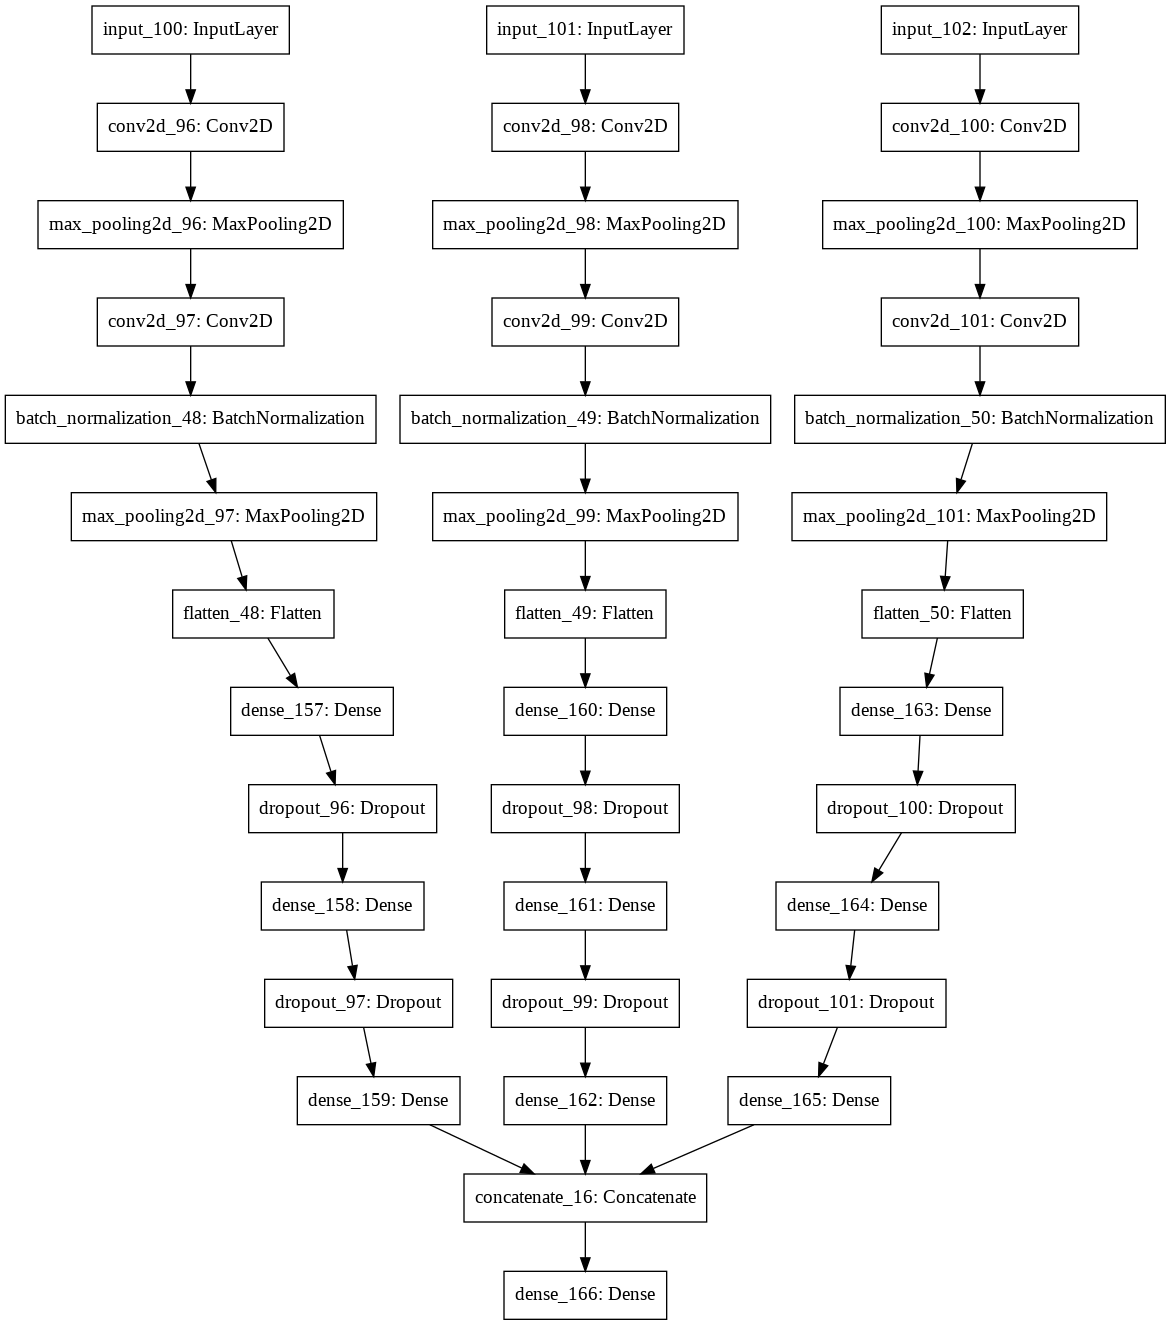

In [372]:
plot_model(final_model, to_file='functional_model.png')

In [373]:
train_data = ([coronal_mensicus, axial_mensicus, sagittal_mensicus])

In [374]:
train_labels = np.array(coronal_mensicus_label)

In [375]:
validation_data = ([coronal_mensicus_val, axial_mensicus_val, sagittal_mensicus_val])

In [376]:
validation_labels = np.array(coronal_mensicus_label_val)

In [377]:
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
def model_train(model, model_name, num_epochs, train_data, train_labels, validation_data, validation_labels):
    '''this function fits the training data and save the weights and model'''
    path_dir = '/content/drive/MyDrive' 
    path = f'{path_dir}/{model_name}//func_weights.h5'
    checkpoint_path = f'{path_dir}//{model_name}//func_model.h5'
    
    sgd = optimizers.SGD(learning_rate=1e-4, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy', Precision(name='precision')])
    
    history = model.fit(x=train_data, y=train_labels, 
            batch_size=32, 
            validation_data=(validation_data, validation_labels),
            epochs=num_epochs, 
            callbacks = [EarlyStopping(patience=3, monitor = 'val_loss', mode = 'min'),
                        ModelCheckpoint(filepath=checkpoint_path, monitor = 'val_loss', save_best_only=True)], 
            verbose=1)

    model.save_weights(path)
    
    return model, history

Batch_size is small at 16, given that previous large numbers resulted in validation accuracy fluctuating up and down. It seems that a larger batch may result in degradation of the quality of the model, since the model lacks the ability to generalise the dataset. 
<br>
<br> The exact amount of patience will vary between models and problems. There a rule of thumb to make it 10% of number of epoch. Patience was kept at 2, since from previous models, overfitting occur very early during training (val_loss > training_loss). So it was better to stop it early, rather than have a higher value for patience. 

In [378]:
def plot_results(model):
    '''this function plots the results of the model'''
    train_loss = model.history['loss']
    test_loss = model.history['val_loss']
    acc = model.history['accuracy']
    val_acc = model.history['val_accuracy']
    prec = model.history['precision']
    val_prec = model.history['val_precision']
    epoch_labels = model.epoch

    fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True)

    axes[0].plot(train_loss, label='Training Loss', color='#185fad')
    axes[0].plot(test_loss, label='Testing Loss', color='orange')

    axes[1].plot(acc, label='Training accuracy', color='blue')
    axes[1].plot(val_acc, label='Testing accuracy', color='red')
    
    axes[2].plot(prec, label='Training precision', color='blue')
    axes[2].plot(val_prec, label='Testing precision', color='red')
    
    # Set title
    axes[0].title.set_text('Training and Testing Loss by Epoch')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Binary Crossentropy')
    
    axes[1].title.set_text('Training and Testing Accuracy by Epoch')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Binary Crossentropy')

    axes[2].title.set_text('Training and Testing Precision by Epoch')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Binary Crossentropy')
    
    plt.xticks(epoch_labels, epoch_labels);    
    
    axes[0].legend(fontsize=18);
    axes[1].legend(fontsize=18);
    axes[2].legend(fontsize=18);

**predictions for meniscus dataset**

Epoch 1/20
36/36 [==============================] - 7s 138ms/step - loss: 0.9639 - accuracy: 0.4850 - precision: 0.3552 - val_loss: 0.9518 - val_accuracy: 0.5250 - val_precision: 0.2727
Epoch 2/20
36/36 [==============================] - 4s 117ms/step - loss: 0.9605 - accuracy: 0.5035 - precision: 0.3723 - val_loss: 0.9512 - val_accuracy: 0.5417 - val_precision: 0.3333
Epoch 3/20
36/36 [==============================] - 4s 117ms/step - loss: 0.9598 - accuracy: 0.5062 - precision: 0.3565 - val_loss: 0.9507 - val_accuracy: 0.5667 - val_precision: 0.5000
Epoch 4/20
36/36 [==============================] - 4s 118ms/step - loss: 0.9592 - accuracy: 0.5301 - precision: 0.3782 - val_loss: 0.9502 - val_accuracy: 0.5667 - val_precision: 0.5000
Epoch 5/20
36/36 [==============================] - 4s 117ms/step - loss: 0.9617 - accuracy: 0.5053 - precision: 0.3347 - val_loss: 0.9498 - val_accuracy: 0.5583 - val_precision: 0.3333
Epoch 6/20
36/36 [==============================] - 4s 117ms/step - lo

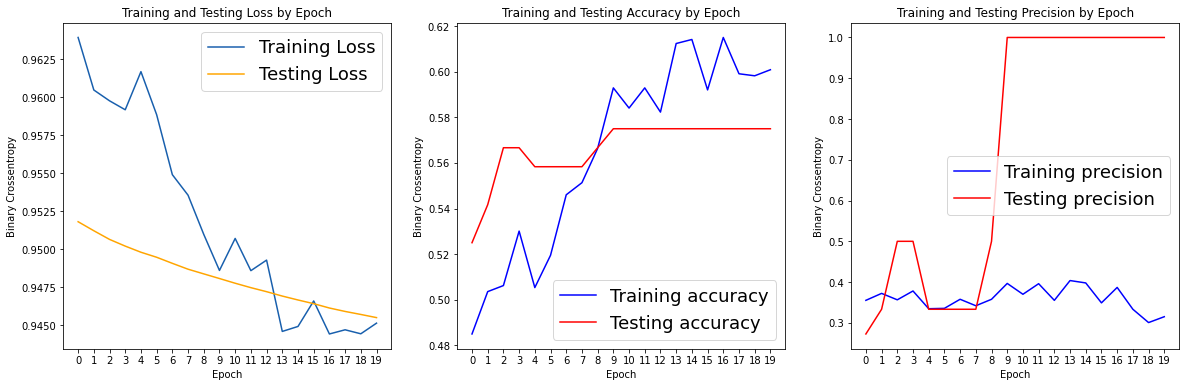

In [399]:
# coronal plane
num_epochs=20

func_men_model, func_men = model_train(final_model, 'func_men', num_epochs, train_data, train_labels, validation_data, validation_labels)

# get/plot accuracy/precision
func_men_acc=[]
func_men_prec=[]
func_men_acc.append(np.mean(func_men.history['val_accuracy']))
func_men_prec.append(np.mean(func_men.history['val_precision']))
plot_results(func_men)

**overview of average accuracy/precision**

In [380]:
# val_accuracy
[func_men_acc]

[[0.45833333730697634]]

In [381]:
# val_precision
[func_men_prec]

[[0.4229453057050705]]

## Evaluate results 

**Evaluate results of training set**

In [382]:
train_scores = func_men_model.evaluate(train_data, np.array(coronal_mensicus_label), verbose=0)
print('Training loss:', train_scores[0]) 
print('Training accuracy:', train_scores[1])

Training loss: 0.9495949149131775
Training accuracy: 0.6212389469146729


**Evaluate results of validation set**

In [383]:
test_scores = func_men_model.evaluate(validation_data, np.array(coronal_mensicus_label_val), verbose=0)
print('Test loss:', test_scores[0]) 
print('Test accuracy:', test_scores[1])

Test loss: 0.9523506164550781
Test accuracy: 0.5416666865348816


**Evaluate predictions for training set**

In [384]:
path_dir = '/content/drive/MyDrive' 
saved_model = load_model(f'{path_dir}//func_men//func_model.h5')

pred = saved_model.predict(train_data) 

In [385]:
pred

array([[0.49353206],
       [0.49206322],
       [0.48482695],
       ...,
       [0.49017867],
       [0.50152916],
       [0.49217442]], dtype=float32)

In [386]:
pred = pd.DataFrame(pred,columns=['predict'])

In [387]:
# since model output is [0,1] using sigmoid activation function
# pred is the probability
pred['predict'] = pred['predict'].map(lambda x: 0 if x<0.5 else 1)

In [388]:
pred['true'] = coronal_mensicus_label

In [389]:
pred[pred['true'] != pred['predict']].shape

(428, 2)

In [390]:
pred[pred['true'] != pred['predict']]

,predict,true
1,0,1
3,0,1
5,0,1
10,0,1
17,1,0
...,...,...
1116,0,1
1117,0,1
1120,0,1
1125,0,1


**Evaluate predictions for validation set**

In [391]:
path_dir = '/content/drive/MyDrive' 
saved_model = load_model(f'{path_dir}//func_men//func_model.h5')

pred_val = saved_model.predict(validation_data) 

In [392]:
pred_val = pd.DataFrame(pred_val,columns=['predict'])


In [393]:
# if prob<0.5, it is 0.
pred_val['predict'] = pred_val['predict'].map(lambda x: 0 if x<0.5 else 1)

In [394]:
pred_val['predict'].value_counts()

0    101
1     19
Name: predict, dtype: int64

In [395]:
pred_val['true'] = coronal_mensicus_label_val

In [396]:
pred_val[pred_val['true'] != pred_val['predict']].shape

(55, 2)

In [397]:
pred_val[pred_val['true'] != pred_val['predict']]

,predict,true
0,1,0
2,1,0
9,1,0
20,1,0
37,1,0
40,1,0
43,0,1
44,0,1
46,0,1
47,1,0


**export results to csv**

In [398]:
pred.to_csv('/content/drive/MyDrive//func_pred_men_results.csv')
pred_val.to_csv('/content/drive/MyDrive//func_pred_val_men_results.csv')